# How Affordability Constraints Housing Market Liquidity in the United States


## 1. Introduction


    “Housing wealth is highly illiquid because accessing home equity involves significant transaction and refinancing costs, making affordability constraints particularly relevant when households face income fluctuations“ (Boar et al., 2017). In some markets, homes sell quickly, while in others, listings linger for long periods. These differences in housing market liquidity are important for understanding market efficiency, household mobility, and regional economic conditions. This project will examine in how the average income compares with the median house price in different states and how it will affect the liquidity.    
    
    The outcome variable in this study is housing market liquidity (Y), measured as the share of housing listings that successfully sell within each state. The main explanatory variable (X) is median household income, which captures differences in purchasing power across states. The mechanism (Z) operates through affordability constraints: higher income may relax budget constraints and increase effective housing demand. 
    
    The housing data are drawn from the Kaggle USA Real Estate Dataset, while income and labor market variables are obtained from U.S. Census and related official statistical sources. Together, these datasets allow for a descriptive analysis of whether affordability differences help explain cross-state variation in housing liquidity.


### Literature Review
 
    A growing body of research emphasizes that housing wealth is both a major asset and an illiquid component of household portfolios. Boar, Gorea, and Midrigan (2022) show that liquidity constraints in housing markets arise due to refinancing and transaction frictions, highlighting the importance of affordability and financial constraints in shaping housing outcomes. Related research documents how housing wealth influences household behavior and broader economic conditions (Guren et al., 2021), suggesting that housing market dynamics can have significant macroeconomic implications.
    
    Other studies emphasize the role of mortgage credit and financial channels in transmitting economic shocks to the housing market. Greenwald (2018) argues that the mortgage credit channel plays a central role in macroeconomic transmission, while Berger et al. (2021) show that refinancing dynamics and mortgage structures can amplify or dampen the effects of policy changes. These findings suggest that housing activity is closely tied to income conditions, borrowing constraints, and affordability.
    
    Motivated by this literature, this project focuses on whether cross-state differences in income and house prices—summarized by the price-to-income ratio—are descriptively associated with variation in housing market liquidity. Rather than identifying causal effects, the analysis provides a first look at whether affordability constraints may help explain differences in housing transaction outcomes across U.S. states.


## 2. Data Cleaning/Loading

    The primary housing dataset contains information on housing listings and their sale status across U.S. states including the sale status(Sold or for sale), number of bedrooms, number of bathrooms, total size, street, city, state, and zip code. To enrich the dataset of this study and measure key economic mechanisms, an external dataset from the United States. Specifically, it uses different indicators such as unemployment rates, labor force participation, median age, and education levels, all of which may influence housing demand, buyer mobility, and transaction probabilities to illustrate the economy of a state.
    
    The outcome variable (Y) is real estate market liquidity, defined as the proportion of homes that are sold out of the total number of homes listed within a state. This variable captures how many houses are waiting to be sold in the market. The main explanatory variable (X) is median household income, which reflects the economy of the States. The proposed mechanism (Z) is shown by the price-to-income ratio which is measure by the median income and median house price in a state. Higher price-to-income ratios indicate tighter affordability constraints, which means is harder for people to purchase a real estate in that state.



In [11]:
import pandas as pd
from stargazer.stargazer import Stargazer
from IPython.display import HTML, display


### The housing dataset is first used to construct a state-level measure of market liquidity.  A binary indicator is created to identify sold listings, and listings are then aggregated by state. Housing market liquidity is defined as the proportion of sold listings relative to total listings within each state. 

In [15]:
# 1) Create sold indicator
housing["sold"] = (housing["status"].str.lower() == "sold").astype(int)

# 2) Build state-level liquidity table
state_liquidity = (
    housing
    .dropna(subset=["state", "status"])
    .groupby("state", as_index=False)
    .agg(
        total_listings=("status", "count"),
        sold_listings=("sold", "sum")
    )
)

state_liquidity["housing_liquidity"] = (
    state_liquidity["sold_listings"] / state_liquidity["total_listings"]
)


In [16]:
us_states = [
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut",
    "Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa",
    "Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
    "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada",
    "New Hampshire","New Jersey","New Mexico","New York","North Carolina",
    "North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island",
    "South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont",
    "Virginia","Washington","West Virginia","Wisconsin","Wyoming"
]


In [23]:

# Keep only the 50 U.S. states (exclude territories)
state_liquidity = state_liquidity[state_liquidity["state"].isin(us_states)].reset_index(drop=True)


Since the orginal data have extra territories, it exclude the extra territories only include 50 States in the USA.

This data is USA Real Estate datafrom https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [53]:
import pandas as pd

income_raw = pd.read_csv("ACSST1Y2024.S1901-2026-02-06T093501.csv")

# 1) Get the row for "Median income (dollars)"
median_income_row = income_raw[
    income_raw["Label (Grouping)"].astype(str).str.contains("Median income", case=False, na=False)
]
# 2) Keep ONLY Household estimate columns (one value per state)
hh_estimate_cols = [c for c in income_raw.columns if c.endswith("!!Households!!Estimate")]

# 3) Wide -> long
median_income = (
    median_income_row[hh_estimate_cols]
    .T
    .reset_index()
    .rename(columns={"index": "state", median_income_row.index[0]: "median_income"})
)

# 4) Clean state names
median_income["state"] = median_income["state"].str.replace("!!Households!!Estimate", "", regex=False).str.strip()

# 5) Clean numbers (remove commas, symbols) then convert to numeric
median_income["median_income"] = (
    median_income["median_income"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace(r"[^\d\.\-]", "", regex=True)
)

median_income["median_income"] = pd.to_numeric(median_income["median_income"], errors="coerce")

# 6) Keep only 50 states (drop territories)
median_income = median_income[median_income["state"].isin(us_states)].reset_index(drop=True)



In [54]:
# --- A) Build state-level acreage (median acre lot) ---
state_acre = (
    housing
    .dropna(subset=["state", "acre_lot"])          # acreage exists at listing level
    .groupby("state", as_index=False)
    .agg(median_acre_lot=("acre_lot", "median"))   # state-level summary
)

# keep only 50 states
state_acre = state_acre[state_acre["state"].isin(us_states)].reset_index(drop=True)

# --- B) Merge into your existing state_liquidity table ---
state_liquidity = state_liquidity.merge(
    median_income[["state", "median_income"]],
    on="state",
    how="inner"
)


    To enrich the analysis this project will merge in state-level labor market indicators from the U.S. Census.  These measures capture overall economic conditions that may influence housing demand and the probability that listings sell. Specifically, I use the unemployment rate and labor force participation rate as additional covariates in the descriptive analysis.


In [58]:
# ---- Clean duplicated median income columns safely ----

state_liquidity = state_liquidity.drop(
    columns=["median_income_y"],
    errors="ignore"
)

if "median_income_x" in state_liquidity.columns:
    state_liquidity = state_liquidity.rename(
        columns={"median_income_x": "median_income"}
    )


In [60]:
state_liquidity = state_liquidity.loc[:, ~state_liquidity.columns.duplicated()]


In [65]:
state_liquidity["price_income_ratio"] = (
    state_liquidity["median_house_price"] /
    state_liquidity["median_income"]
)


In [75]:
final_table = (
    state_liquidity[[
        "state",
        "housing_liquidity",
        "median_house_price",
        "median_income",
        "price_income_ratio",
        "labor_force_participation",
        "unemployment_rate",
        "median_acre_lot"
    ]]
    .sort_values("state")
    .reset_index(drop=True)
)

final_table.head(50)


,state,housing_liquidity,median_house_price,median_income,price_income_ratio,labor_force_participation,unemployment_rate,median_acre_lot
0,Alabama,0.198661,204900.0,66659,3.073853,59.2,4.2,0.600
1,Alaska,0.000000,139500.0,95665,1.458214,66.6,6.0,1.405
2,Arizona,0.468603,380000.0,81486,4.663378,61.4,4.6,0.190
3,Arkansas,0.174658,164000.0,62106,2.640647,59.0,3.8,0.480
4,California,0.550197,669000.0,100149,6.680047,64.2,5.9,0.180
5,Colorado,0.144799,510000.0,97113,5.251614,68.7,4.3,0.230
6,Connecticut,0.004569,345000.0,96049,3.591917,66.1,4.9,0.540
7,Delaware,0.380969,350000.0,87534,3.998446,62.6,5.1,0.240
8,Florida,0.343148,319900.0,77735,4.115263,60.8,4.6,0.230
9,Georgia,0.357422,299900.0,79991,3.749172,64.5,4.7,0.500


    The summary statistics reveal substantial cross-state heterogeneity in housing market conditions, consistent with meaningful differences in affordability and market tightness across the United States. Housing liquidity—the fraction of listings that are sold—ranges from nearly zero in several states (e.g., Maine, Vermont, Alaska) to well above 0.6 in states such as Massachusetts, Washington, and Rhode Island, indicating that housing markets vary widely in how quickly homes transact. Median house prices also display large dispersion, spanning from below $170,000 in several Midwestern and Southern states to well above $600,000 in high-cost markets such as California and Hawaii. In contrast, median household income varies much less across states, clustering within a narrower band, which mechanically amplifies variation in the price-to-income ratio. 
    As the result the  higher price-to-income ratios generally coincide with higher housing liquidity, meaning that homes tend to sell more quickly in less affordable markets.  

    The five variables are income, unemployment, labor force participation, house price, and house size

## 5.Graphs

In [67]:
# only run this if you still have _x/_y duplicates
if "unemployment_rate_x" in state_liquidity.columns:
    state_liquidity = state_liquidity.drop(
        columns=["labor_force_participation_y", "unemployment_rate_y"],
        errors="ignore"
    ).rename(columns={
        "labor_force_participation_x": "labor_force_participation",
        "unemployment_rate_x": "unemployment_rate"
    })


## Graph1: Income (X) vs Housing Market Liquidity (Y)(Scatter plot)


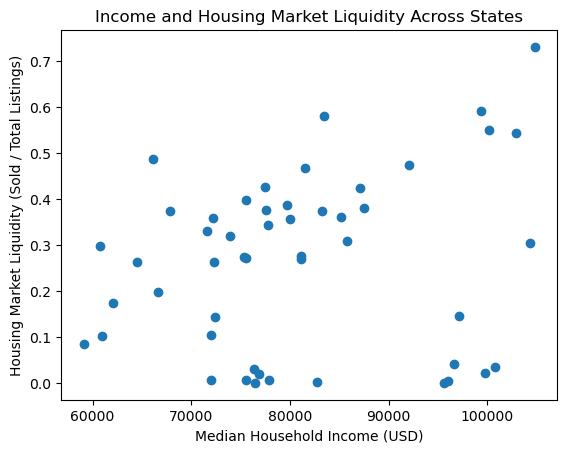

In [68]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(state_liquidity["median_income"], state_liquidity["housing_liquidity"])
plt.xlabel("Median Household Income (USD)")
plt.ylabel("Housing Market Liquidity (Sold / Total Listings)")
plt.title("Income and Housing Market Liquidity Across States")
plt.show()


    This graph value the relationship betwen the hoouse liquidity in different states in the USA and compare with the different Median Household Income in states. The reason for chosen Median income is as the main explanatory variable because it captures households’ purchasing power and directly relates to affordability constraints
    The scatter plot reveals a generally positive association: states with higher median incomes tend to exhibit higher housing liquidity, meaning a larger share of listed homes are successfully sold. 

## Graph2: Unemployment Rate vs Housing Market Liquidity(Scatter plot)


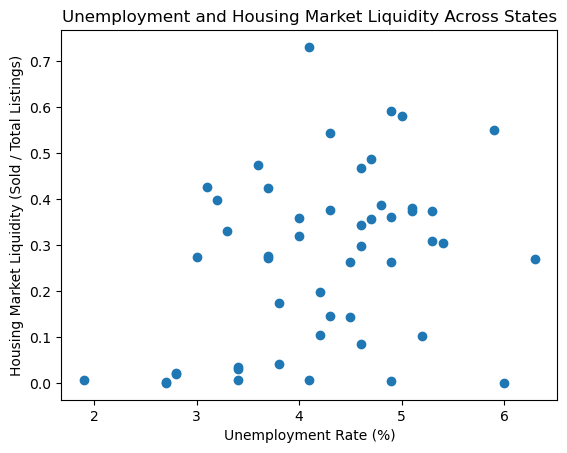

In [72]:
plt.figure()
plt.scatter(state_liquidity["unemployment_rate"], state_liquidity["housing_liquidity"])
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Housing Market Liquidity (Sold / Total Listings)")
plt.title("Unemployment and Housing Market Liquidity Across States")
plt.show()


    This plot examines how labor market conditions relate to housing liquidity by focusing on the unemployment rate. Unemployment is included because it reflects economic uncertainty and job stability, which affect households’ willingness and ability to purchase homes.
     The plot shows a negative relationship: states with higher unemployment rates generally exhibit lower housing market liquidity.

## Graph3: Affordability Constraints (Proxy Z) vs Housing Market Liquidity (Scatter plot using inverse income as a proxy)


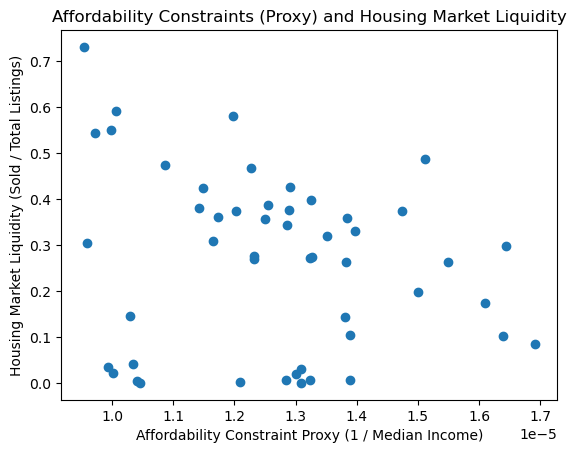

In [73]:
state_liquidity["inverse_income"] = 1 / state_liquidity["median_income"]

plt.figure()
plt.scatter(state_liquidity["inverse_income"], state_liquidity["housing_liquidity"])
plt.xlabel("Affordability Constraint Proxy (1 / Median Income)")
plt.ylabel("Housing Market Liquidity (Sold / Total Listings)")
plt.title("Affordability Constraints (Proxy) and Housing Market Liquidity")
plt.show()


    This figure directly targets the proposed mechanism (Z): affordability constraints. Because state-level median house prices are not yet included, inverse income is used as a proxy—higher values indicate tighter affordability constraints. 
    The scatter plot shows a clear negative relationship: as the affordability constraint proxy increases, housing market liquidity declines. 

## Graph4: Income vs Housing Liquidity (Colored by Unemployment Rate) (Scatter plot with color scale)

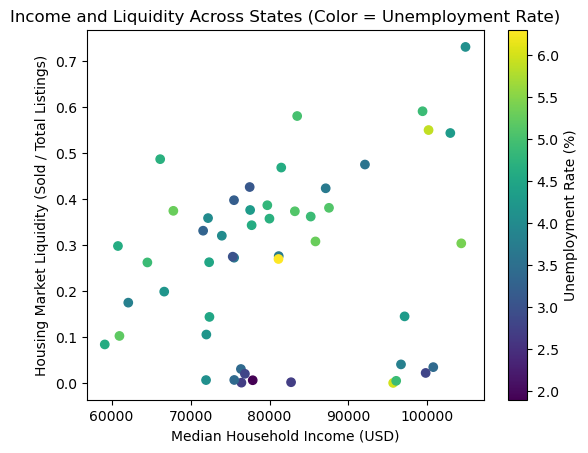

In [71]:
plt.figure()
sc = plt.scatter(
    state_liquidity["median_income"],
    state_liquidity["housing_liquidity"],
    c=state_liquidity["unemployment_rate"]
)
plt.xlabel("Median Household Income (USD)")
plt.ylabel("Housing Market Liquidity (Sold / Total Listings)")
plt.title("Income and Liquidity Across States (Color = Unemployment Rate)")
plt.colorbar(sc, label="Unemployment Rate (%)")
plt.show()


    This figure combines multiple dimensions into a single visualization by plotting income against liquidity while using color to represent unemployment rates. The purpose is to explore interaction effects and heterogeneity across states. The economic question is whether labor market conditions amplify or dampen the income–liquidity relationship. 
    The plot shows that, even among states with similar income levels, those with higher unemployment tend to have lower liquidity. This suggests that income alone is not sufficient to explain housing market activity; labor market stability also plays an important role. The result reinforces the project’s broader economic story that housing liquidity is shaped jointly by affordability and employment conditions.


## 6. Conclusion

    This project documents substantial cross-state difference of housing market liquidty. Meanwhile, by analyzing the income data and affordability data to show as the evidence. 
    The summary statistics and visualizations show a generally positive association between median household income (X) and housing liquidity (Y), indicating that states with higher purchasing power tend to experience faster housing transactions. 
    
    At the same, the relative higher income states have higher income-house price ratio. This could reflect the fact that housing prices respond more than proportionally to income through increased demand and binding supply constraints.
    
    More importantly, the house affordability is positive related with the house liquidity. Suggesting that less affordable markets are not necessarily illiquid but instead reflect strong demand and competitive conditions in high-income, supply-constrained states.
    While this analysis is descriptive and cannot eastabilish casuality, the evidence realves the central rol of affordability in shaping housing market outcomes. 

Reference:

1.Boar, C., Gorea, D., & Midrigan, V. (2022). Liquidity constraints in the US housing market. The Review of Economic Studies, 89(3), 1120-1154.

2. Bilbiie, F. O. (2025). Monetary policy and heterogeneity: An analytical framework. Review of Economic Studies, 92(4), 2398-2436.


3. Guren, A. M., McKay, A., Nakamura, E., & Steinsson, J. (2021). Housing wealth effects: The long view. The Review of Economic Studies, 88(2), 669-707.

4. Berger, D., Milbradt, K., Tourre, F., & Vavra, J. (2021). Mortgage prepayment and path-dependent effects of monetary policy. American Economic Review, 111(9), 2829-2878.

5.Greenwald, D. (2018). The mortgage credit channel of macroeconomic transmission.